# 4. Using subdomain scheduling - (1+1)D Burgers' equation

This notebook shows you how to use subdomains scheduling to train a FBPINN.

# What is subdomain scheduling?

An advantage of using domain decomposition for FBPINNs is that we can control which **parts** of the domain are solved at each training step.

This is useful if we want to control how boundary conditions are **communicated** across the domain.

For example, we can define a **time-stepping scheduler** to solve time-dependent PDEs, and learn the solution forwards in time from a set of initial conditions (see gif below).

This is done by specifying a **subdomain scheduler** (from `fbpinns.schedulers`), which defines which subdomains are actively training and which subdomains have fixed parameters at each training step.

# Problem overview

In this example we will use a time-stepping subdomain scheduler to train a FBPINN to solve the (1+1)D time-dependent Burgers' equation:

<img src="../images/scheduling.gif" width="70%">

The exact partial differential equation (PDE) and boundary conditions we will solve for are:

$$
\dfrac{\partial u}{\partial t} + u \dfrac{\partial u}{\partial x} = \nu \dfrac{\partial^2 u}{\partial x^2}
$$

Where $u(x,t)$ is the speed of the fluid and $\nu$ defines the scalar viscosity of the flow.

This exact problem is already defined in the `fbpinns.problems.BurgersEquation2D` problem class.

# Workflow overview

We will use the following steps to define a scheduler and train the FBPINN:
1. Define a `fbpinns.schedulers.ActiveScheduler` class
2. Train the FBPINN using this `ActiveScheduler` class

## Step 1: Define a `fbpinns.schedulers.ActiveScheduler` class

### Inheriting the `ActiveScheduler` class

All scheduler classes should inherit from the base `fbpinns.schedulers.ActiveScheduler` class:

```python
class ActiveScheduler:
    """Base scheduler class to be inherited by different schedulers"""

    def __init__(self, all_params, n_steps):
        self.n_steps = n_steps
        self.m = all_params["static"]["decomposition"]["m"]
        self.xd = all_params["static"]["decomposition"]["xd"]

    def __len__(self):
        return self.n_steps

    def __iter__(self):
        """
        Returns None if active array not to be changed, otherwise active array.
        active is an array of length m, where each value corresponds
        to the state of each model (i.e. subdomain), which can be one of:

        0 = inactive (but still trained if it overlaps with active models)
        1 = active
        2 = fixed
        """

        raise NotImplementedError
```

`ActiveScheduler`s are simply **Python iterables** which output an `active` array, which is a flat vector which indicates which subdomains are active or fixed at each training step.

During training, the scheduler is iterated over and if the `active` array changes, the input training points to the FBPINN and the trained subdomains are changed appropriately.

The length of the active array should equal the number of subdomains in the FBPINN, which is stored in the `all_params["static"]["decomposition"]["m"]` parameter.

### Using a pre-defined `ActiveScheduler`

There are some pre-defined `ActiveScheduler`s in `fbpinns.schedulers`. In particular for the problem above we can use `fbinns.schedulers.LineSchedulerRectangularND` to time-step, which is appropriate for the `RectangularDecompositionND` class.

In this case all we need to do is define the initialisation values of the class:

```python
scheduler_kwargs = dict(
    point=[0.], iaxis=0,
)
```

which indicates the starting time of the scheduler ($t=0$) and the axis along which the line of active models is defined (the $x$-axis). 

## Step 2: Train the FBPINN using this `ActiveScheduler` class

Finally, we can train a `FBPINN` using this `ActiveScheduler` class:

[INFO] 2025-03-30 18:17:31 - <fbpinns.constants.Constants object at 0x7fb2fc4d0150>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([-1.,  0.]), 'xmax': array([1., 1.])}
problem: <class 'fbpinns.problems.BurgersEquation2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
       -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
        0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
        0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ]), array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])], 'subdomain_ws': [array([0.30526316, 0.30526316, 0.30526316, 0.30526316, 0.30526316,
       0.30526316, 0.30526316, 0.30526316, 0.30526316, 0.30526316,
   

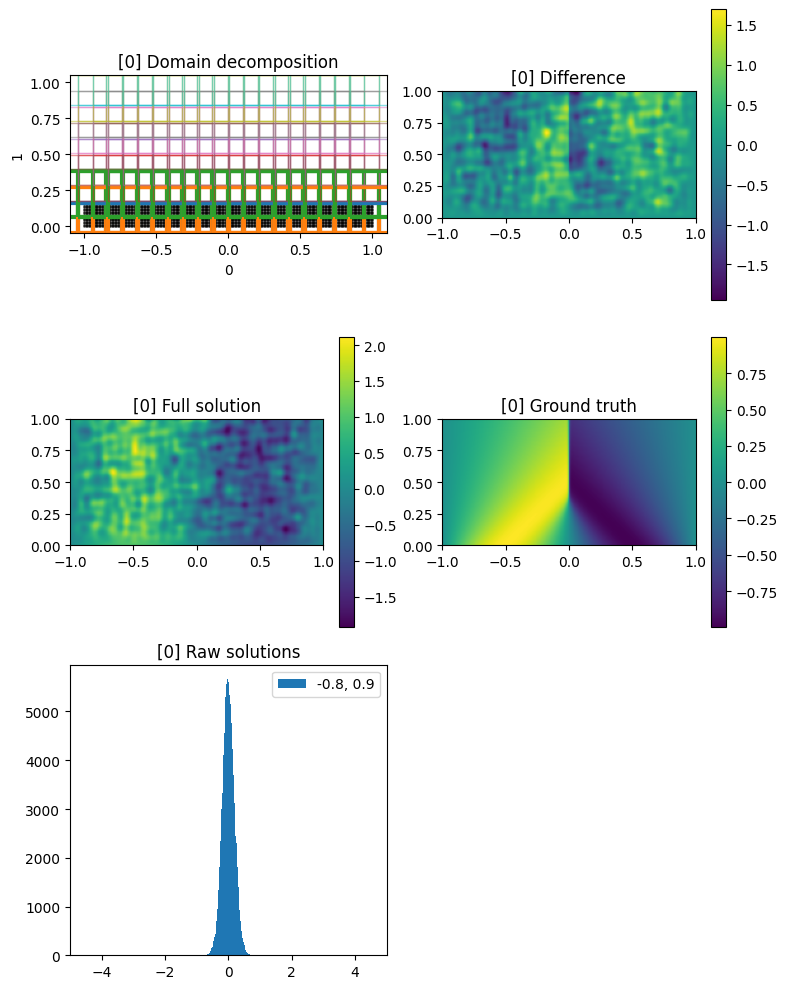

[INFO] 2025-03-30 18:17:40 - [i: 1000/50000] loss: 0.0047 rate: 307.0 elapsed: 0.00 hr test
[INFO] 2025-03-30 18:17:41 - [i: 2000/50000] loss: 0.0010 rate: 2877.7 elapsed: 0.00 hr test
[INFO] 2025-03-30 18:17:41 - [i: 2632/50000] Updating active inputs..
[INFO] 2025-03-30 18:17:41 - [i: 2632/50000] Average number of points/dimension in active subdomains: 27.74
[INFO] 2025-03-30 18:17:42 - [i: 2632/50000] Updating active inputs done (1.39 s)
[INFO] 2025-03-30 18:17:42 - [i: 2632/50000] Compiling update step..
[INFO] 2025-03-30 18:17:42 - x_batch
[INFO] 2025-03-30 18:17:42 - (5400, 2), float32, JVPTracer
[INFO] 2025-03-30 18:17:42 - x_take
[INFO] 2025-03-30 18:17:42 - (41040, 2), float32, JVPTracer
[INFO] 2025-03-30 18:17:42 - x_batch
[INFO] 2025-03-30 18:17:42 - (5400, 2), float32, JVPTracer
[INFO] 2025-03-30 18:17:42 - x_take
[INFO] 2025-03-30 18:17:42 - (41040, 2), float32, JVPTracer
[INFO] 2025-03-30 18:17:44 - [i: 2632/50000] Compiling done (1.60 s)
[INFO] 2025-03-30 18:17:44 - [i: 

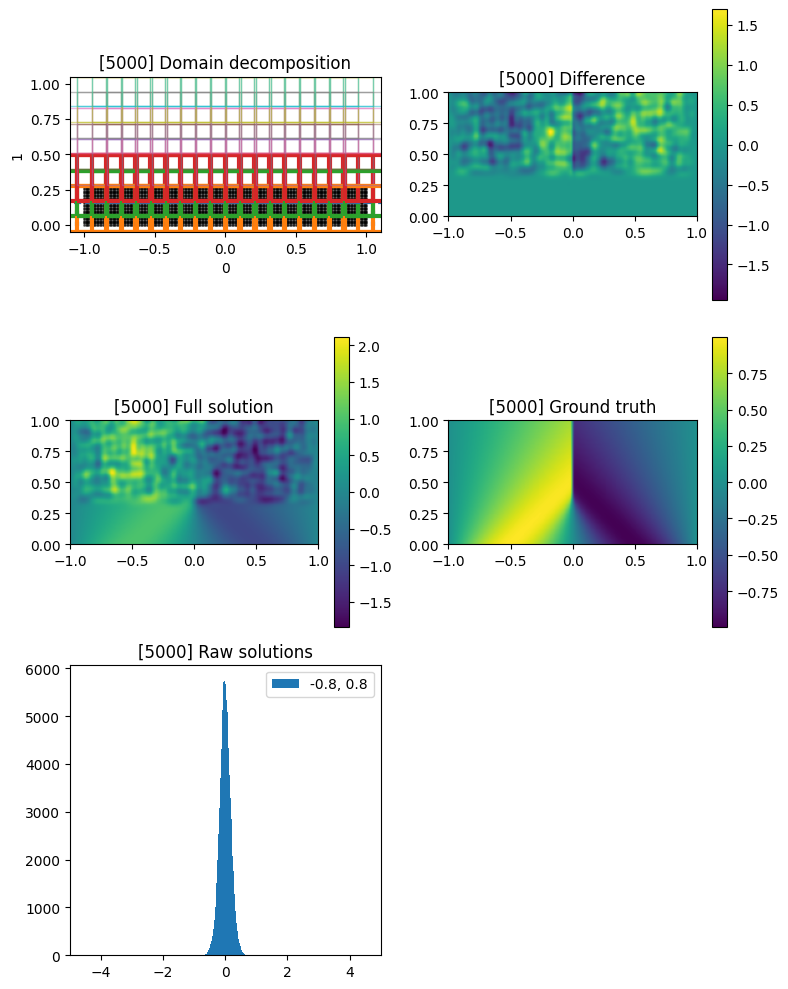

[INFO] 2025-03-30 18:17:47 - [i: 6000/50000] loss: 0.0006 rate: 1768.0 elapsed: 0.00 hr test
[INFO] 2025-03-30 18:17:47 - [i: 7000/50000] loss: 0.0006 rate: 1773.5 elapsed: 0.00 hr test
[INFO] 2025-03-30 18:17:48 - [i: 7895/50000] Updating active inputs..
[INFO] 2025-03-30 18:17:48 - [i: 7895/50000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-30 18:17:49 - [i: 7895/50000] Updating active inputs done (1.37 s)
[INFO] 2025-03-30 18:17:49 - [i: 7895/50000] Compiling update step..
[INFO] 2025-03-30 18:17:49 - x_batch
[INFO] 2025-03-30 18:17:49 - (6200, 2), float32, JVPTracer
[INFO] 2025-03-30 18:17:49 - x_take
[INFO] 2025-03-30 18:17:49 - (50730, 2), float32, JVPTracer
[INFO] 2025-03-30 18:17:49 - x_batch
[INFO] 2025-03-30 18:17:49 - (6200, 2), float32, JVPTracer
[INFO] 2025-03-30 18:17:49 - x_take
[INFO] 2025-03-30 18:17:49 - (50730, 2), float32, JVPTracer
[INFO] 2025-03-30 18:17:51 - [i: 7895/50000] Compiling done (1.65 s)
[INFO] 2025-03-30 18:17:51 - [i:

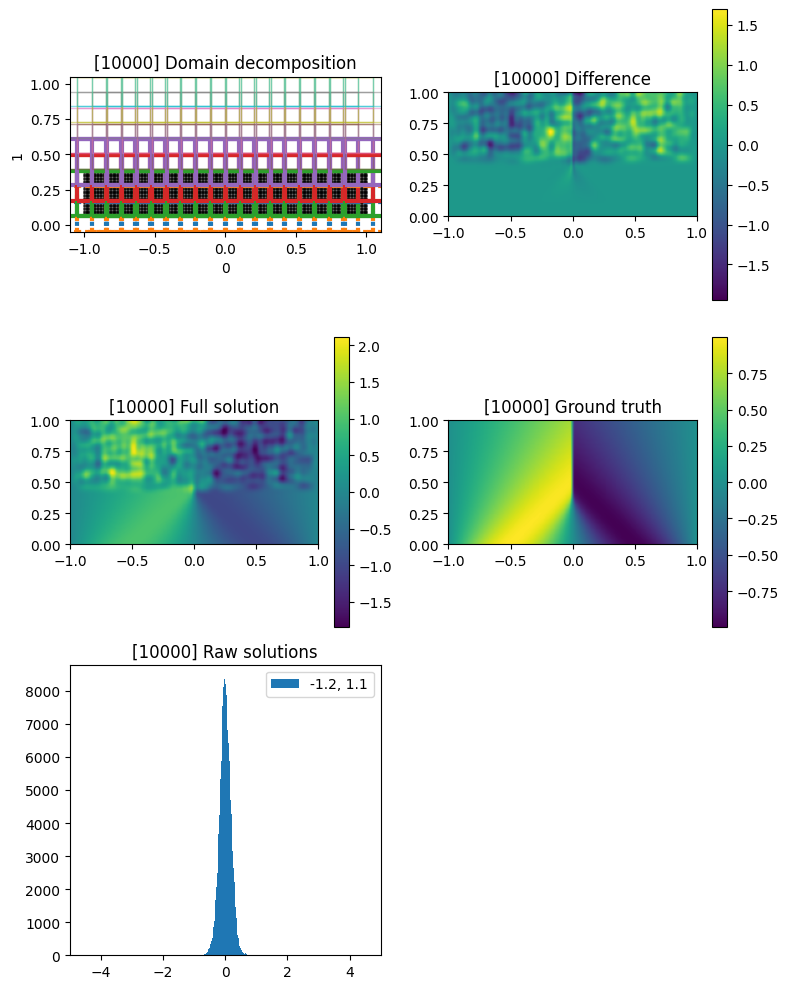

[INFO] 2025-03-30 18:17:53 - [i: 11000/50000] loss: 0.0324 rate: 1443.2 elapsed: 0.00 hr test
[INFO] 2025-03-30 18:17:54 - [i: 12000/50000] loss: 0.0324 rate: 1467.9 elapsed: 0.00 hr test
[INFO] 2025-03-30 18:17:55 - [i: 13000/50000] loss: 0.0321 rate: 1580.0 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:17:55 - [i: 13158/50000] Updating active inputs..
[INFO] 2025-03-30 18:17:55 - [i: 13158/50000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-30 18:17:55 - [i: 13158/50000] Updating active inputs done (0.15 s)
[INFO] 2025-03-30 18:17:55 - [i: 13158/50000] Compiling update step..
[INFO] 2025-03-30 18:17:55 - [i: 13158/50000] Compiling done (0.02 s)
[INFO] 2025-03-30 18:17:56 - [i: 14000/50000] loss: 0.2371 rate: 1251.6 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:17:56 - [i: 15000/50000] loss: 0.2291 rate: 1577.5 elapsed: 0.01 hr test
(20000, 2) (20000, 1) (20000, 1) (155040, 1) (155040, 1) (155040, 1) (6200, 2) (200, 100)
True


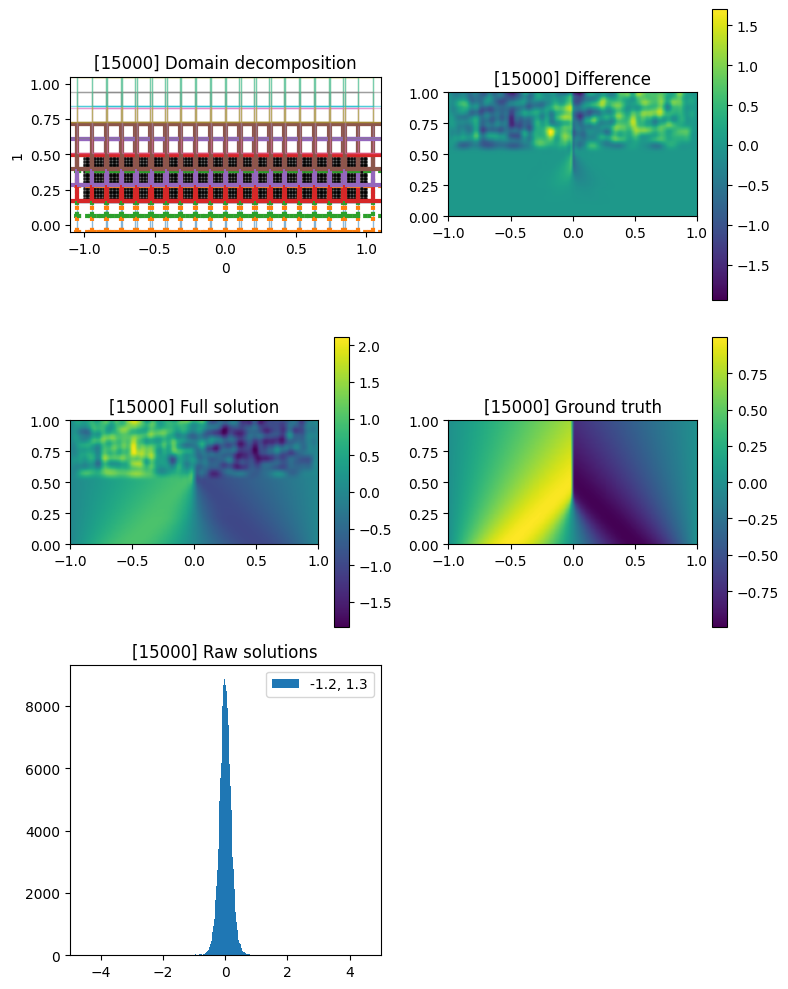

[INFO] 2025-03-30 18:17:57 - [i: 16000/50000] loss: 0.2269 rate: 1583.3 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:17:58 - [i: 17000/50000] loss: 0.2259 rate: 1578.3 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:17:59 - [i: 18000/50000] loss: 0.2248 rate: 1579.0 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:17:59 - [i: 18422/50000] Updating active inputs..
[INFO] 2025-03-30 18:17:59 - [i: 18422/50000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-30 18:17:59 - [i: 18422/50000] Updating active inputs done (0.04 s)
[INFO] 2025-03-30 18:17:59 - [i: 18422/50000] Compiling update step..
[INFO] 2025-03-30 18:17:59 - [i: 18422/50000] Compiling done (0.03 s)
[INFO] 2025-03-30 18:17:59 - [i: 19000/50000] loss: 0.4098 rate: 1424.6 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:00 - [i: 20000/50000] loss: 0.3983 rate: 1574.5 elapsed: 0.01 hr test
(20000, 2) (20000, 1) (20000, 1) (155040, 1) (155040, 1) (155040, 1) (6200, 2) (200, 100)
True


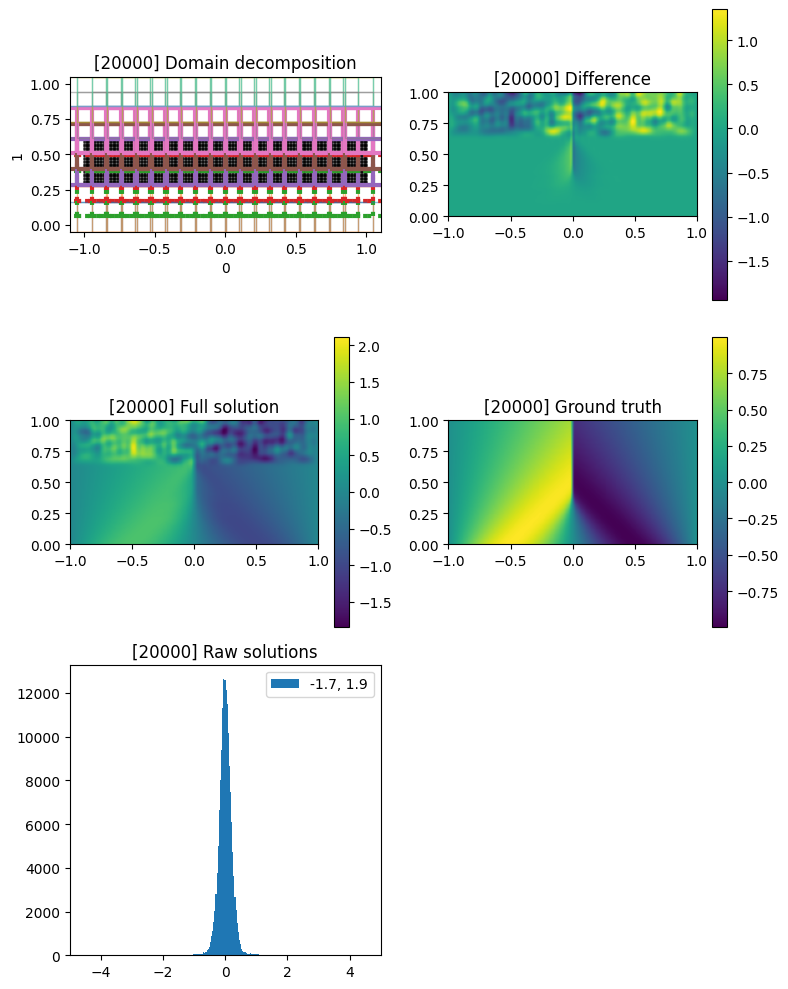

[INFO] 2025-03-30 18:18:01 - [i: 21000/50000] loss: 0.3952 rate: 1526.3 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:02 - [i: 22000/50000] loss: 0.3933 rate: 1481.1 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:03 - [i: 23000/50000] loss: 0.3920 rate: 1446.2 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:03 - [i: 23685/50000] Updating active inputs..
[INFO] 2025-03-30 18:18:03 - [i: 23685/50000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-30 18:18:03 - [i: 23685/50000] Updating active inputs done (0.03 s)
[INFO] 2025-03-30 18:18:03 - [i: 23685/50000] Compiling update step..
[INFO] 2025-03-30 18:18:03 - [i: 23685/50000] Compiling done (0.02 s)
[INFO] 2025-03-30 18:18:03 - [i: 24000/50000] loss: 0.4742 rate: 1425.2 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:04 - [i: 25000/50000] loss: 0.4385 rate: 1496.6 elapsed: 0.01 hr test
(20000, 2) (20000, 1) (20000, 1) (155040, 1) (155040, 1) (155040, 1) (6200, 2) (200, 100)
True


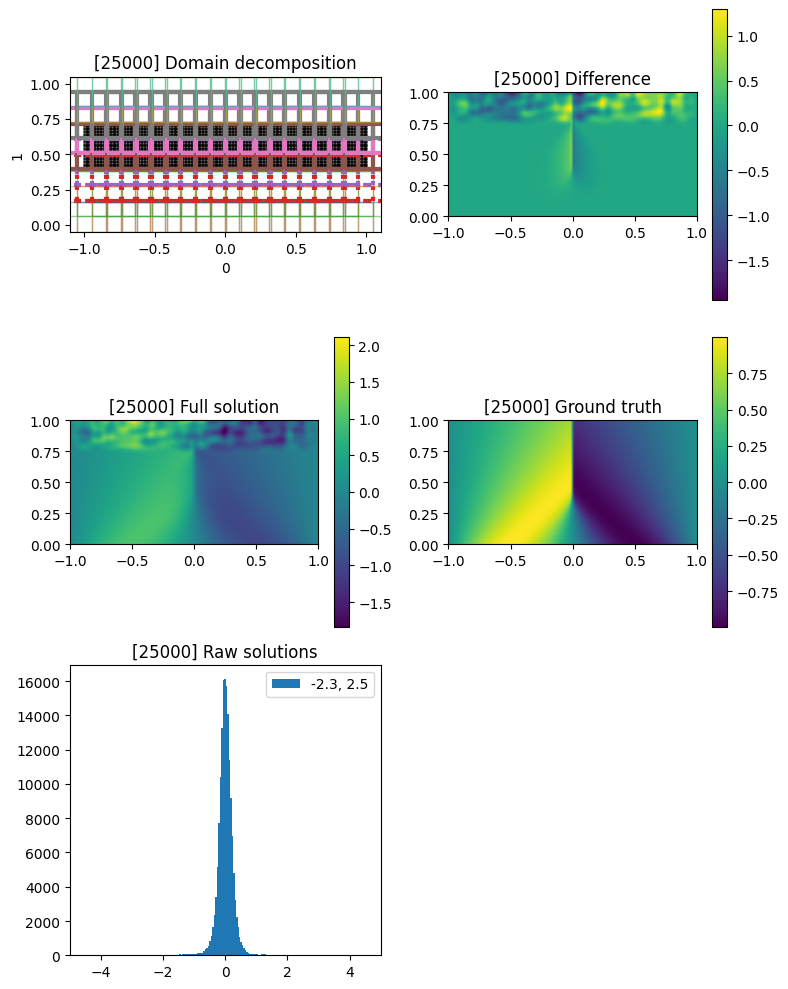

[INFO] 2025-03-30 18:18:05 - [i: 26000/50000] loss: 0.4344 rate: 1471.6 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:06 - [i: 27000/50000] loss: 0.4325 rate: 1557.2 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:07 - [i: 28000/50000] loss: 0.4305 rate: 1365.5 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:07 - [i: 28948/50000] Updating active inputs..
[INFO] 2025-03-30 18:18:07 - [i: 28948/50000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-30 18:18:07 - [i: 28948/50000] Updating active inputs done (0.04 s)
[INFO] 2025-03-30 18:18:07 - [i: 28948/50000] Compiling update step..
[INFO] 2025-03-30 18:18:07 - [i: 28948/50000] Compiling done (0.03 s)
[INFO] 2025-03-30 18:18:07 - [i: 29000/50000] loss: 0.4980 rate: 1380.3 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:08 - [i: 30000/50000] loss: 0.3786 rate: 1458.6 elapsed: 0.01 hr test
(20000, 2) (20000, 1) (20000, 1) (155040, 1) (155040, 1) (155040, 1) (6200, 2) (200, 100)
True


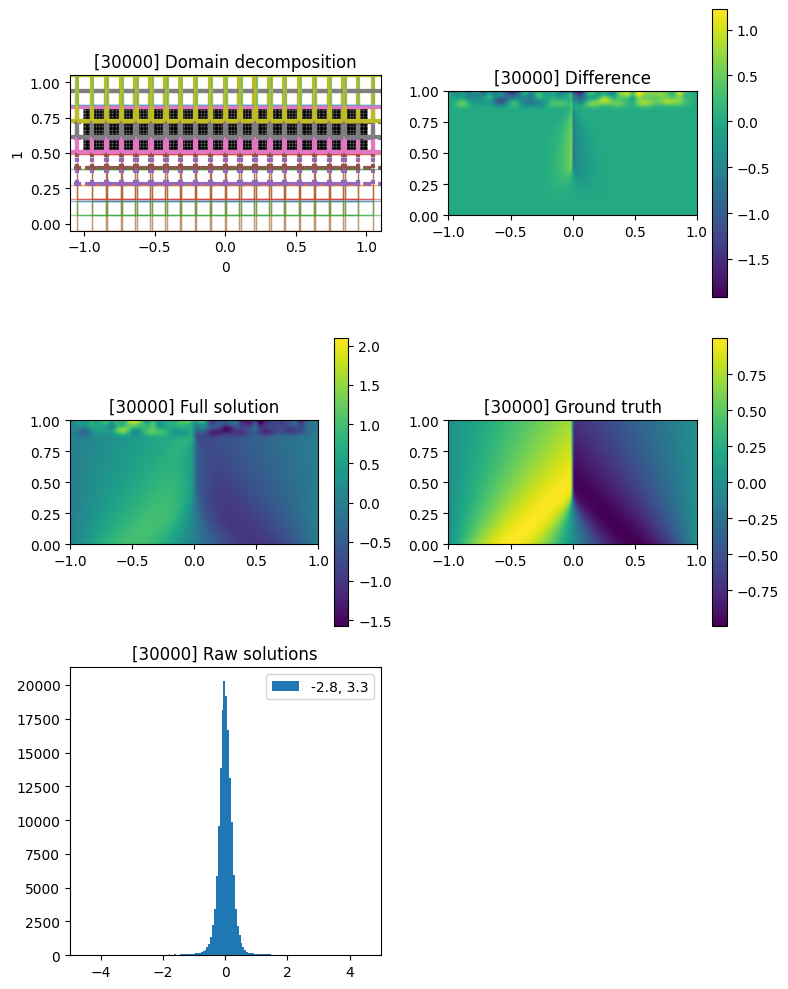

[INFO] 2025-03-30 18:18:09 - [i: 31000/50000] loss: 0.3748 rate: 1312.2 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:10 - [i: 32000/50000] loss: 0.3727 rate: 1449.5 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:11 - [i: 33000/50000] loss: 0.3705 rate: 1522.7 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:12 - [i: 34000/50000] loss: 0.3682 rate: 1555.6 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:12 - [i: 34211/50000] Updating active inputs..
[INFO] 2025-03-30 18:18:12 - [i: 34211/50000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-30 18:18:12 - [i: 34211/50000] Updating active inputs done (0.06 s)
[INFO] 2025-03-30 18:18:12 - [i: 34211/50000] Compiling update step..
[INFO] 2025-03-30 18:18:12 - [i: 34211/50000] Compiling done (0.03 s)
[INFO] 2025-03-30 18:18:12 - [i: 35000/50000] loss: 0.2948 rate: 1380.9 elapsed: 0.01 hr test
(20000, 2) (20000, 1) (20000, 1) (155040, 1) (155040, 1) (155040, 1) (6200, 2) (200, 100)
True


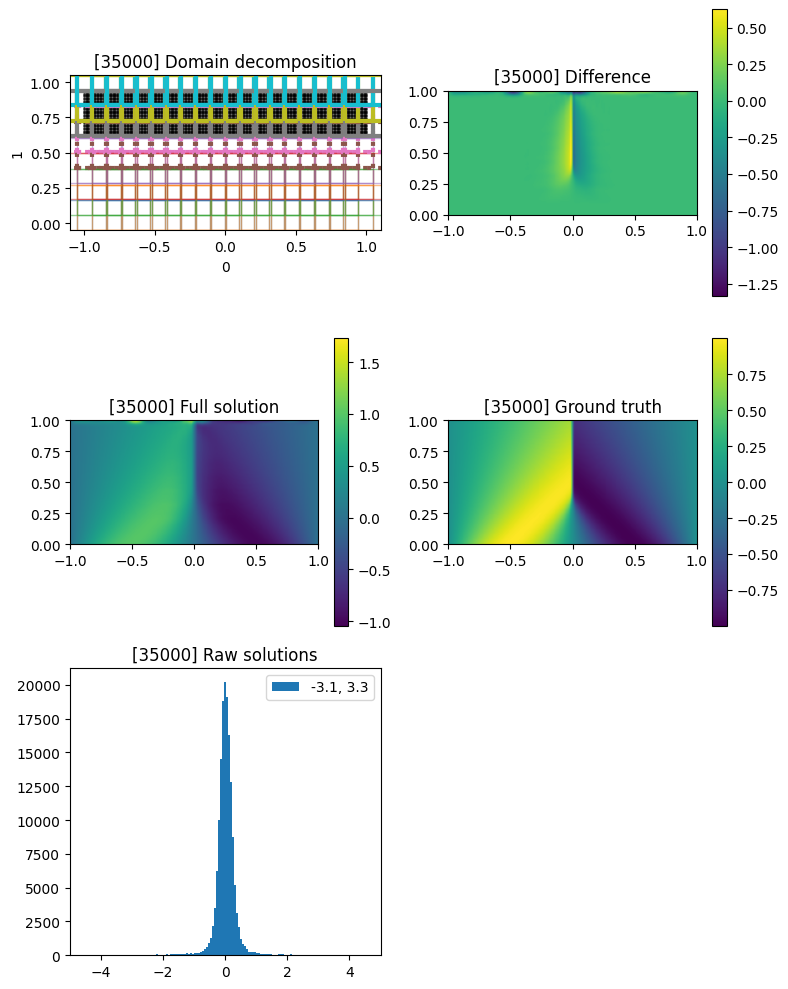

[INFO] 2025-03-30 18:18:13 - [i: 36000/50000] loss: 0.2895 rate: 1568.2 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:14 - [i: 37000/50000] loss: 0.2875 rate: 1558.3 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:15 - [i: 38000/50000] loss: 0.2859 rate: 1563.3 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:15 - [i: 39000/50000] loss: 0.2841 rate: 1557.4 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:16 - [i: 39474/50000] Updating active inputs..
[INFO] 2025-03-30 18:18:16 - [i: 39474/50000] Average number of points/dimension in active subdomains: 27.74
[INFO] 2025-03-30 18:18:16 - [i: 39474/50000] Updating active inputs done (0.07 s)
[INFO] 2025-03-30 18:18:16 - [i: 39474/50000] Compiling update step..
[INFO] 2025-03-30 18:18:16 - x_batch
[INFO] 2025-03-30 18:18:16 - (5400, 2), float32, JVPTracer
[INFO] 2025-03-30 18:18:16 - x_take
[INFO] 2025-03-30 18:18:16 - (41040, 2), float32, JVPTracer
[INFO] 2025-03-30 18:18:16 - x_batch
[INFO] 2025-03-30 18:18:16 - (5400, 2), float32, JVPTracer
[IN

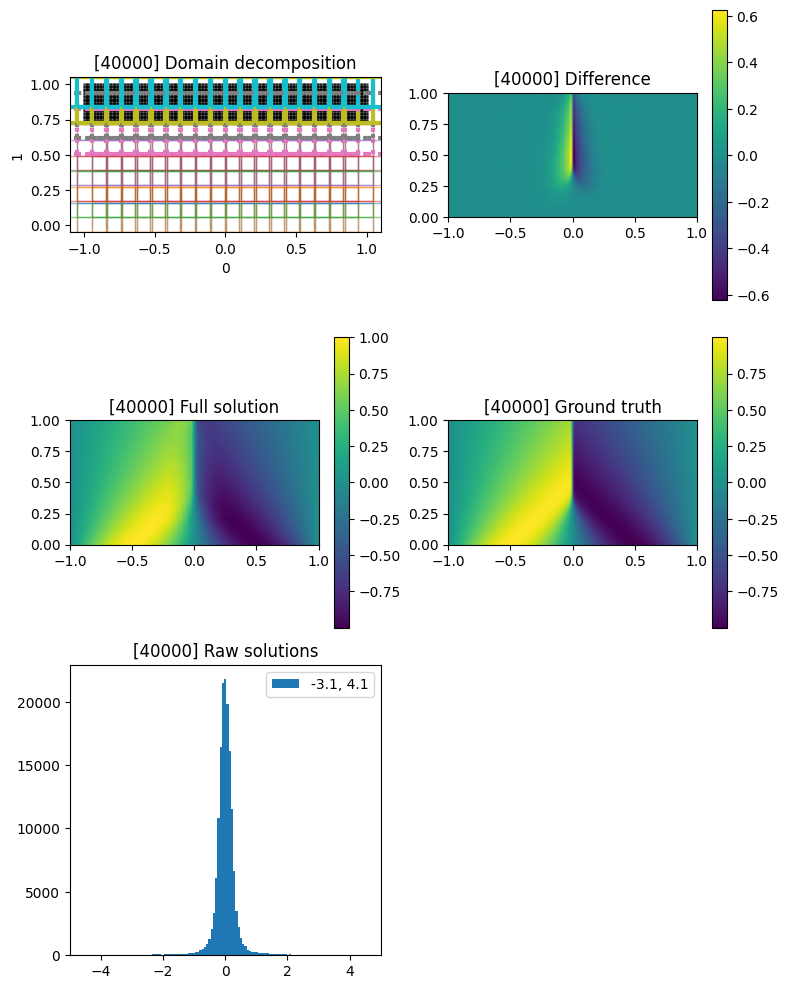

[INFO] 2025-03-30 18:18:19 - [i: 41000/50000] loss: 0.2253 rate: 1944.8 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:19 - [i: 42000/50000] loss: 0.2243 rate: 1990.5 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:20 - [i: 43000/50000] loss: 0.2230 rate: 1637.4 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:20 - [i: 44000/50000] loss: 0.2218 rate: 1997.1 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:21 - [i: 44737/50000] Updating active inputs..
[INFO] 2025-03-30 18:18:21 - [i: 44737/50000] Average number of points/dimension in active subdomains: 21.35
[INFO] 2025-03-30 18:18:21 - [i: 44737/50000] Updating active inputs done (0.05 s)
[INFO] 2025-03-30 18:18:21 - [i: 44737/50000] Compiling update step..
[INFO] 2025-03-30 18:18:21 - x_batch
[INFO] 2025-03-30 18:18:21 - (3200, 2), float32, JVPTracer
[INFO] 2025-03-30 18:18:21 - x_take
[INFO] 2025-03-30 18:18:21 - (23370, 2), float32, JVPTracer
[INFO] 2025-03-30 18:18:21 - x_batch
[INFO] 2025-03-30 18:18:21 - (3200, 2), float32, JVPTracer
[IN

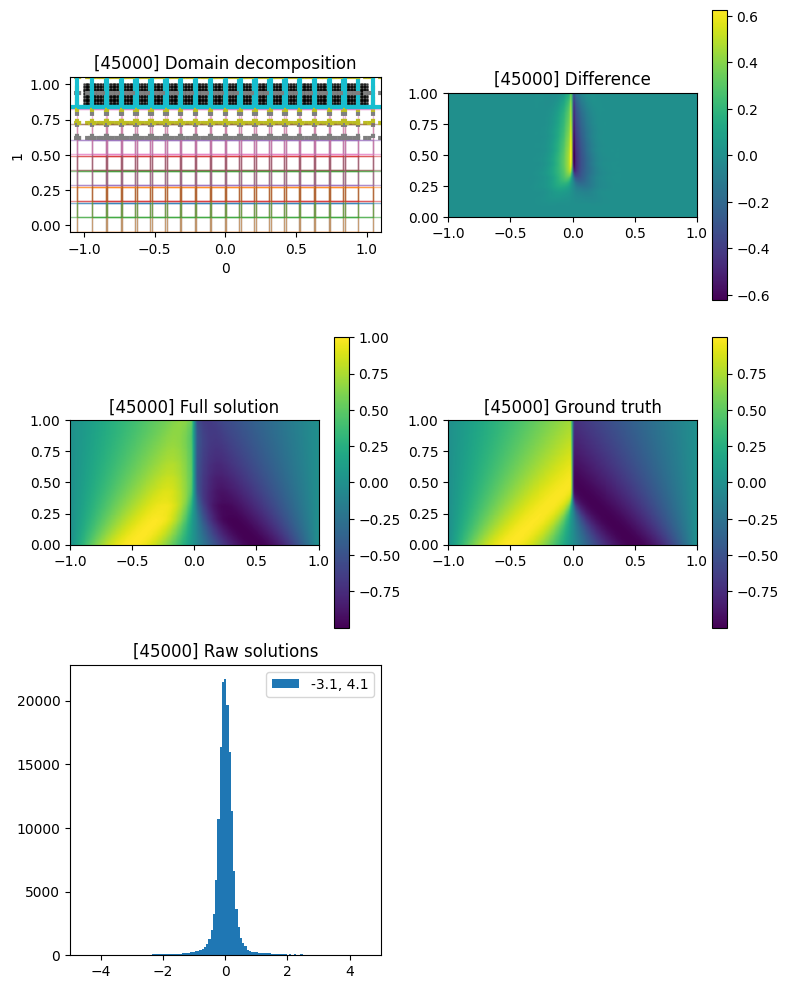

[INFO] 2025-03-30 18:18:23 - [i: 46000/50000] loss: 0.1614 rate: 3442.1 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:24 - [i: 47000/50000] loss: 0.1588 rate: 2532.8 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:24 - [i: 48000/50000] loss: 0.1566 rate: 3255.3 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:24 - [i: 49000/50000] loss: 0.1541 rate: 3469.0 elapsed: 0.01 hr test
[INFO] 2025-03-30 18:18:25 - [i: 50000/50000] loss: 0.1520 rate: 3371.8 elapsed: 0.01 hr test
(20000, 2) (20000, 1) (20000, 1) (155040, 1) (155040, 1) (155040, 1) (3200, 2) (200, 100)
True


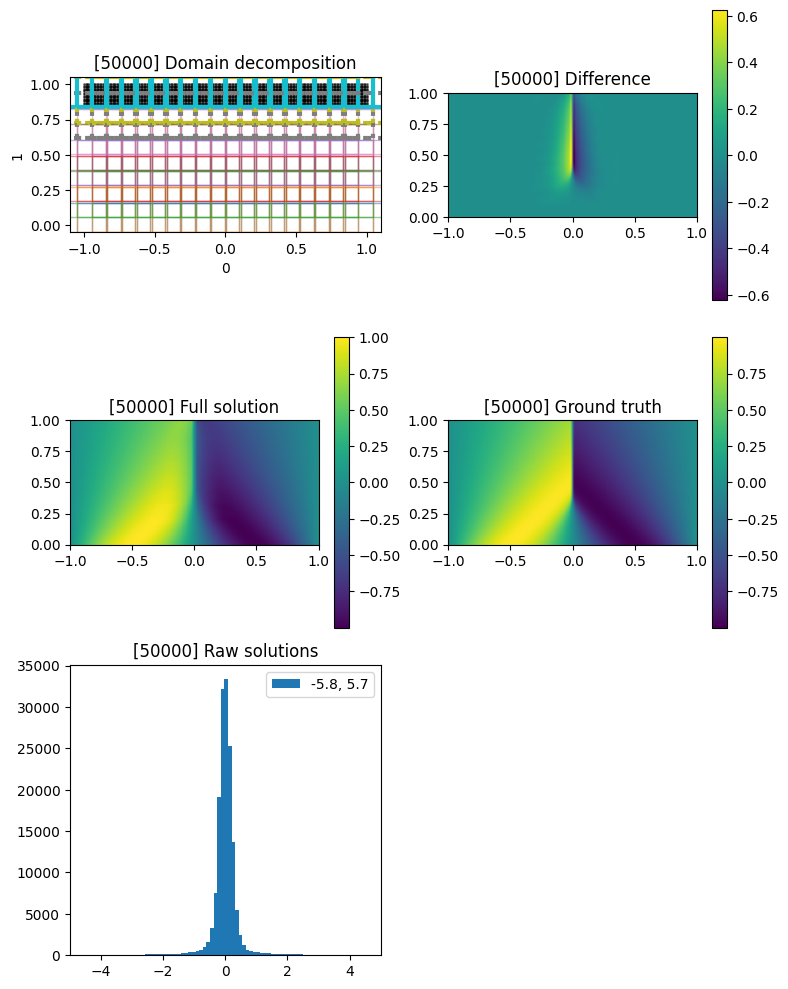

[INFO] 2025-03-30 18:18:25 - [i: 50000/50000] Training complete


In [2]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.problems import BurgersEquation2D
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer, PINNTrainer

subdomain_xs=[np.linspace(-1,1,20), np.linspace(0,1,10)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([-1,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=BurgersEquation2D,
    problem_init_kwargs = dict(),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 16, 1),
    # ),
    network=ChebyshevKAN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=1,
        degree=9
    ),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=0,
    ),
    ns=((200,100),),
    n_test=(200,100),
    n_steps=50000,
    clear_output=False,
)

run = FBPINNTrainer(c)
# run = PINNTrainer(c)
all_params = run.train()